# Main approaches to dimensionality reduction

### Projection and Manifold learning

•	Projection is done when training instances lie closer to each other in a low dimensional sub-space of a high dimensional space.<br><br>
•	However, projecting is not always ideal. Imagine you project a Swiss roll into 2-D. It would make it squash different layers onto it and there will be overlaps. You would rather unroll it than to project it. <br><br>
•	This is an example of a 2-D manifold. A d-dimensional manifold is a part of an n-dimensional space (where d < n) that locally resembles a d-dimensional hyperplane. Manifold hypothesis is that most high dimensional data in world lies close to low dimensional manifold. <br>


<b>However, dimentionality reduction will not always lead to higher performance or simpler dataset. It can only guarantee better speeds. Hence, always train your models firstly on original datasets.<b>

# Techniques/Algorithms for dimensionality reduction

# 1) PCA: Projection

It chooses the right hyperplane on which the dataset shows/preserves maximum variance to gain minimum information loss. Another way to think about this is that it finds the axis that minimizes the mean squared distance between the original data and the projected data.

### Finding PC using SVD

The method involves matrix factorisation technique called Singular Value Decomposition (SVD).

In [114]:
import numpy as np

np.random.seed(42)

X = (np.random.rand(25,3) * 100).round(0)
X_centered = X - X.mean(axis=0)
U, s, Vt = np.linalg.svd(X_centered)

The variable Vt contains are desired PC's.<br>
Don't forget to center the data if your are doing SVD manually. However, PCA class of Scikit Learn takes care of this itself.

In [116]:
W = Vt[:2].T
X2D = X_centered @ W

To get our number of dimensions, we multiply our reduced data with the transpose of weights. It is because the transpose of weights or more specifically <b><u>'Vt'</u></b> inverse is equivalent to its transpose. 

In [117]:
X3D = X2D @ W.T

### Finding PC using Scikit's PCA class

In [63]:
from sklearn.decomposition import PCA

pca = PCA(n_components = 2 )
X2D = pca.fit_transform(X)

### Explained Variance and finding right amount of features

In [66]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', as_frame = False)
X_train, y_train = mnist.data[:60000], mnist.target[:60000]
X_test, y_test = mnist.data[60000:], mnist.target[60000:]

pca = PCA()
pca.fit(X_train)
cumsum = np.cumsum(pca.explained_variance_ratio_)

In [85]:
features = np.argmax(cumsum >= 0.95) + 1

You can also set the parameter <b>'n_components'</b> to a floating number from 0.0 to 1.0 which will indicate the ratio of variance.

In [107]:
pca = PCA(n_components=0.95)
X_reduced = pca.fit_transform(X_train)

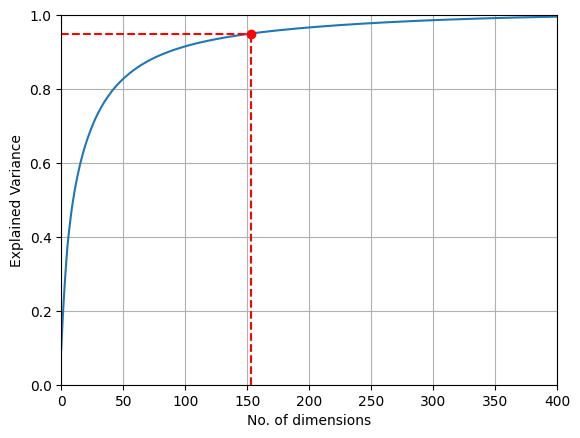

In [100]:
import matplotlib.pyplot as plt

plt.plot(cumsum)
plt.grid()
plt.xlim(0,400)
plt.ylim(0,1)
plt.xlabel('No. of dimensions')
plt.ylabel('Explained Variance')
plt.hlines(0.95, xmin=0, xmax=features-1, linestyles='--', colors='r')
plt.vlines(features-1, ymin = 0, ymax = 0.95, linestyles='--', colors='r')
plt.plot([153],[0.95], 'ro')

In [105]:
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier

clf = make_pipeline(
    PCA(random_state=42),
    RandomForestClassifier(random_state=42)
)

from sklearn.model_selection import RandomizedSearchCV

params = {
    'pca__n_components': np.arange(10,80),
    'randomforestclassifier__n_estimators': np.arange(50,500)
}

rnd = RandomizedSearchCV(clf, param_distributions = params, n_iter=10, cv = 3, random_state=42)

rnd.fit(X_train[1000:2000], y_train[1000:2000])

RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('pca', PCA(random_state=42)),
                                             ('randomforestclassifier',
                                              RandomForestClassifier(random_state=42))]),
                   param_distributions={'pca__n_components': array([10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26,
       27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43,
       44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60,
       6...
       414, 415, 416, 417, 418, 419, 420, 421, 422, 423, 424, 425, 426,
       427, 428, 429, 430, 431, 432, 433, 434, 435, 436, 437, 438, 439,
       440, 441, 442, 443, 444, 445, 446, 447, 448, 449, 450, 451, 452,
       453, 454, 455, 456, 457, 458, 459, 460, 461, 462, 463, 464, 465,
       466, 467, 468, 469, 470, 471, 472, 473, 474, 475, 476, 477, 478,
       479, 480, 481, 482, 483, 484, 485, 486, 487, 488, 489, 490, 491,
       492, 493, 494, 495, 496, 497, 498, 499])},
                   random_state=42)

In [106]:
rnd.best_params_

{'randomforestclassifier__n_estimators': np.int64(314),
 'pca__n_components': np.int64(36)}

### Decompressing data

In [108]:
X_decompressed = pca.inverse_transform(X_reduced)

The recovered data will not be 100% original since we will have to account for the 5% variance that was lost during compression.

### Hyperparameter 'svd_solver'

Set it to 'full', 'random' or 'auto'. 'auto' will automatically use randomized svd if <b><u>max(m, n) > 500</b></u> and <b><u>n_components < 0.8 * min (m, n).</u></b>

### Incremental PCA

This allows us to fit PCA from mini-batches of the training set. This is useful for large training sets or when you are applying PCA online.

In [127]:
from sklearn.decomposition import IncrementalPCA

inc_pca = IncrementalPCA(n_components=154)

for split in np.split(X_train, 100):
    inc_pca.partial_fit(split)

X_new = pca.transform(X_train)

# 2) Random Projection: Projection

PCA becomes too slow when features are too many or when we have large dataset. Thus, we have another technique called ‘Random Projection’.<br><br>

Using random linear projection, data is projected into low-dimensional space. Surprisingly, it preserves distances between 2 instances fairly well. To find the minimum number of dimensions you need that would preserve the distances we will need the number of instances, m, and the squared distance you do not want to change between 2 instances by more than, <b><u>e</b></u>.


In [138]:
from sklearn.random_projection import johnson_lindenstrauss_min_dim

m, e = 500, 0.2
d = johnson_lindenstrauss_min_dim(m, eps=e)
d

np.int64(1434)

Lets suppose the size of original matrix was m = 5_000 x n = 20_000. Now, randomnly generate a matrix, P, of d x n shape which you will use to generate your reduced dataset. Each item in the matrix P will be sampled from Gaussian distribution with mean = 0 and variance = 1/d. This will help us to project dataset from n to d dimensions.

In [184]:
n = 2_000
np.random.seed(42)

P = np.random.randn(d, n) / np.sqrt(d)

X = np.random.randn(m, n)
X_reduced = X @ P.T

In [185]:
inverse = np.linalg.pinv(P.T)
X_decompressed = X_reduced @ inverse

(1434, 2000)

You can also set your own target dimensionality (d) as well with the help of 'n_components' hyperparameter.

In [144]:
from sklearn.random_projection import GaussianRandomProjection

gauss_rnd_proj = GaussianRandomProjection(eps=e, random_state=42)
X_reduced = gauss_rnd_proj.fit_transform(X)

gauss_rnd_proj.components_.shape

(1434, 2000)

A usually preferable class to use for Random Projection is SparseRandomProjection. It outputs the result in sparse matrix which takes less space and faster to calculate. <br>
The ratio (r) of non-zero instances (density) is equal to 1/(n)**0.5 and in this case it is equal to 1/(2000)**0.5.<br>
The non-zero value is either -v or +v and v = 1/(d * r) ** 0.5.

In [156]:
from sklearn.random_projection import SparseRandomProjection

sparse_rnd_proj = SparseRandomProjection(eps=e, random_state=42, dense_output=True)
X_reduced = sparse_rnd_proj.fit_transform(X)

In [164]:
r = 1 / (n) ** 0.5
r ** -1

44.721359549995796

In [166]:
v = 1 / (d * r) ** 0.5
v

np.float64(0.17659683802614895)

In [174]:
(1434 * 2000) / (r ** -1)

64130.42959469397

# 3) LLE: Manifold learning

LLE tries to see how training instance relates to its neighbors and then it tries to unfold/unroll it maintaining this relationship.

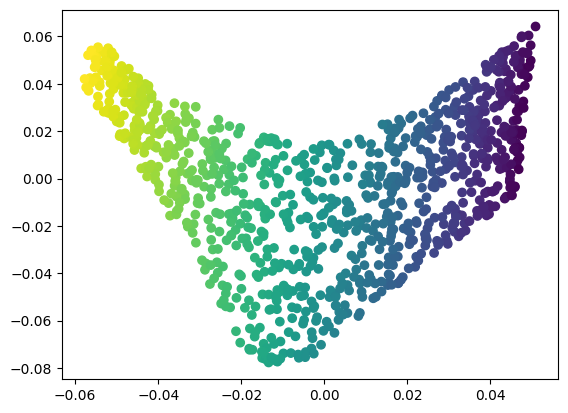

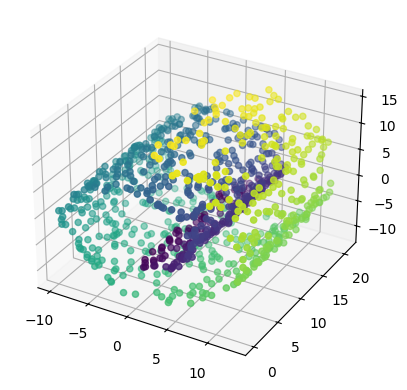

In [87]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_swiss_roll
from sklearn.manifold import LocallyLinearEmbedding

X_swiss, t = make_swiss_roll(n_samples=1000, noise=0.2, random_state=42)
lle = LocallyLinearEmbedding(n_components=2, n_neighbors=10, random_state=42)
unrolled = lle.fit_transform(X_swiss)
plt.scatter(unrolled[:,0], unrolled[:,1], c = t)

fig = plt.figure()
ax = plt.axes(projection = '3d')
ax.scatter3D(X_swiss[:,0], X_swiss[:,1], X_swiss[:,2], c = t)

# 4) Other techniques

In [68]:
from sklearn.manifold import MDS
from sklearn.manifold import Isomap
from sklearn.manifold import TSNE
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

Text(0.5, 1.0, 'MDS')

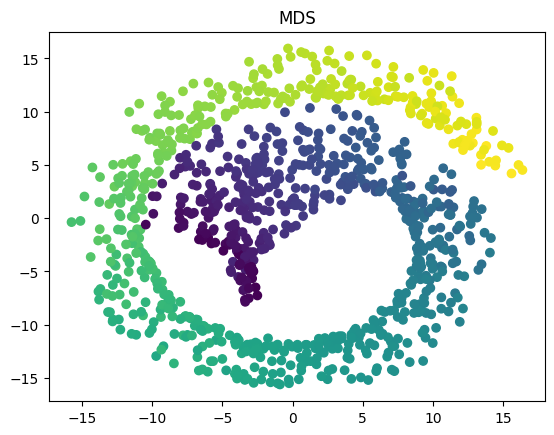

In [77]:
mds = MDS(n_components=2)
X_mds = mds.fit_transform(X_swiss)
plt.scatter(X_mds[:,0], X_mds[:,1], c = t)
plt.title('MDS')

Text(0.5, 1.0, 'Isomap')

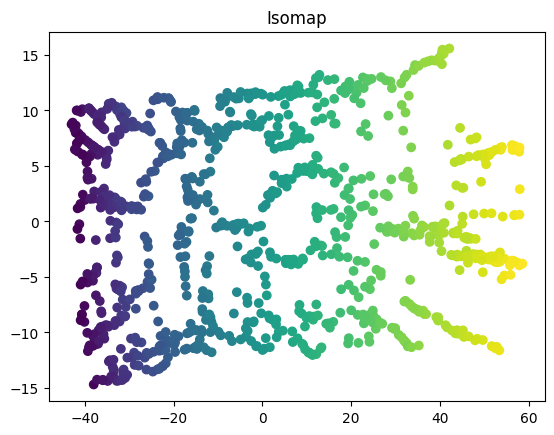

In [79]:
isomap = Isomap(n_components=2)
X_isomap = isomap.fit_transform(X_swiss)
plt.scatter(X_isomap[:,0], X_isomap[:,1], c = t)
plt.title('Isomap')

Text(0.5, 1.0, 'TSNE')

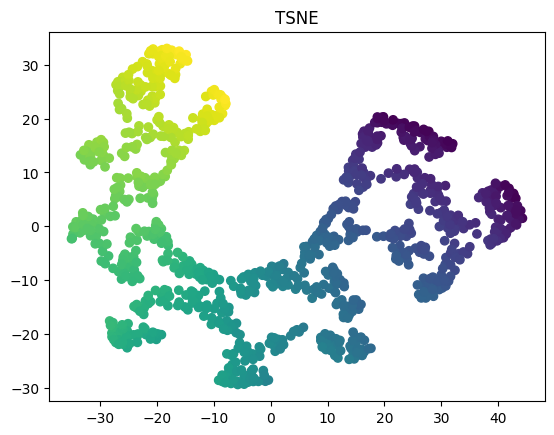

In [81]:
tsne = TSNE(n_components = 2)
X_tsne = tsne.fit_transform(X_swiss)
plt.scatter(X_tsne[:,0], X_tsne[:,1], c = t)
plt.title('TSNE')